In [77]:
# !pip install fasttext -U
# !pip install contractions -U
# !pip install pyspellchecker -U
# !pip install matplotlib -U
# !pip install seaborn -U
# !pip install nltk -U
# !pip install wordcloud -U
# !pip install scikit-learn -U
# !pip install scipy -U
# !pip install certifi
# !pip install pyenchant
# !pip install beautifulsoup4
# !pip install lxml
# !pip install tqdm
# !pip install catboost
# !pip install bayesian-optimization

You should consider upgrading via the 'C:\Users\Gardo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
# !wget -P resources/ 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
# !gdown "0Bz8a_Dbh9QhbZVhsUnRWRDhETzA" -O "resources/dataset.zip"

## Imports

In [62]:
from __future__ import annotations
import pandas as pd
import fasttext
from sklearn.metrics import confusion_matrix, accuracy_score
import keras
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
from typing import List, Callable, Tuple, Any, Iterable
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from keras.src.layers import TextVectorization
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import os
from keras import Sequential
from keras import layers
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from bs4 import BeautifulSoup
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import enchant
import contractions
from nltk.tokenize import word_tokenize
from sklearn.utils.extmath import randomized_svd
from spellchecker import SpellChecker
import nltk
from wordcloud import WordCloud
import re
from sklearn.utils import compute_class_weight
import numpy as np
import pickle
from numpy import diag
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Constants

In [159]:
# OTHER
RESOURCES_FOLDER = 'resources'
FAST_TEXT_MODEL = f'{RESOURCES_FOLDER}/lid.176.bin'
RANDOM_STATE = 1234

# DATASET
DATASET_PATH = f'{RESOURCES_FOLDER}/dataset.csv'
ENCODING_TO_CLASS = {0: 'bad', 1: 'neutral', 2: 'good'}
PREPROCESSED_FOLDER = f'{RESOURCES_FOLDER}/preprocessed'
CONDENSED_DATASET = f'{PREPROCESSED_FOLDER}/condensed_dataset.csv'
ONLY_ENGLISH = f'{PREPROCESSED_FOLDER}/only_english_dataset.csv'
PREPROCESSED_DATASET = f'{PREPROCESSED_FOLDER}/preprocessed_dataset.csv'

# MODELS
MODELS_FOLDER = f'{RESOURCES_FOLDER}/models'
CAT_BOOST = f'{MODELS_FOLDER}/cat_boost.pickle'
MAX_TOKENS = 20_000
BATCH_SIZE = 128
DEFAULT_EPOCHS = 100

# COMPUTED DATA
BINARY_DATA = f'{RESOURCES_FOLDER}/binary_data'
model_predictions = lambda data, predictions_name: np.save(f'{BINARY_DATA}/{predictions_name}.npy', data)

for folder in [PREPROCESSED_FOLDER, MODELS_FOLDER, BINARY_DATA]:
    if not os.path.exists(folder):
        os.makedirs(folder)

## Utility functions

### Save-load binary

In [42]:
def save_numpy(array, file_path):
    np.save(file_path, array)

def load_numpy(file_path):
    return np.load(file_path)

def save_binary(file_path, obj):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)
        
def load_binary(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

- `sample balanced`: takes at most `max_samples_per_class` from each class specified in `groupby_column`
- `compute_languages`: compute language for specified Series. It creates a new Series with `__label__[language]` for each text in the original Series

### DataFrame processing

In [3]:
def sample_balanced(dataframe: pd.DataFrame, 
                    max_samples_per_class: int = 20_000, 
                    groupby_column: str = 'stars', 
                    random_state: int = RANDOM_STATE):
  return dataframe.groupby(groupby_column)\
  .apply(lambda x: x.sample(max_samples_per_class, random_state=random_state))\
  .reset_index(drop=True)

def compute_languages(texts: pd.Series):
  model = fasttext.load_model(FAST_TEXT_MODEL)
  return texts.apply(lambda x: model.predict(x)[0][0])

def set_columns(columns: List[str]):
  def _set_columns(dataframe: pd.DataFrame):
    dataframe.columns = columns
    return dataframe
  return _set_columns

def drop_na():
  def _drop_na(dataframe: pd.DataFrame):
    return dataframe.dropna()
  return _drop_na

def remove_not_modal_languages(extracted_languages: pd.Series):
  def _remove_languages(dataframe: pd.DataFrame):
    modal_language = extracted_languages.value_counts().index[0]
    return dataframe[extracted_languages == modal_language].reset_index(drop=True)
  return _remove_languages

def compute_and_remove_not_modal_languages(text_column: str = 'text'):
  def _compute_and_remove(dataframe: pd.DataFrame):
    computed_languages = compute_languages(dataframe[text_column])
    return remove_not_modal_languages(computed_languages)(dataframe)
  return _compute_and_remove

def apply_preprocess(preprocess_functions: List[Callable]):
  def _apply_preprocess(dataframe: pd.DataFrame):
    for function in preprocess_functions:
      dataframe = function(dataframe)
    return dataframe
  return _apply_preprocess

def save_csv(dataframe: pd.DataFrame, path:str, verbose:bool = True):
    dataframe.to_csv(path, index=False)
    if verbose:
        print('file saved')
        
def load_csv(path:str):
    return pd.read_csv(path)

def apply(series: pd.Series, mapping_function: Callable[[Any], Any]) -> List[Any]:
    return [mapping_function(value) for value in series.values]    

### Text processing

In [4]:
def to_lower(text: str):
  return text.lower()

def expand_contraction(word: str):
  return contractions.fix(word)

def stopwords_list(language='english'):
    return stopwords.words(language)

def is_stopword(language: str = 'english'):
  stopwords_set = stopwords_list(language)
  def _is_stopword(word: str):
    return word in stopwords_set
  return _is_stopword

def is_punctuation(word: str):
  return word in string.punctuation

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def correct_word(language: str = 'eng'):
  checker = SpellChecker(language)
  def _correct_words(word: str):
    return checker.correction(word)
  return _correct_words


def is_in_dictionary(language: str = "en_US"):
    dictionary = enchant.Dict(language)
    def _is_in_dictionary(word: str):
        return dictionary.check(word)
    return _is_in_dictionary

def tokenize(text: str):
  return word_tokenize(text)

def split(text: str):
    return text.split()

def remove_lxml():
    def _remove_lxml(text):
        return BeautifulSoup(text, 'lxml').get_text().strip()
    return _remove_lxml

def expand():
    def _expand(text):
        return contractions.fix(text)
    return _expand
    
def map_text(mapping_function):
    def _map_text(text):
        return mapping_function(text)
    return _map_text

def remove_links():
    link_regex = r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    def _remove_links(text):
        return re.sub(link_regex, "", text)
    return _remove_links
  
def remove_mails():
    mail_regex = r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'
    def _remove_mails(text):
        return re.sub(mail_regex, "", text)
    return _remove_mails      

def remove_stopwords():
    stopword_regex = r'\b(' + r'|'.join(stopwords_list()) + r')\b\s*'
    def _remove_stopwords(text):
        return re.sub(stopword_regex, '', text)
    return _remove_stopwords

def generic_regex(pattern, repl):
    def _generic_regex(text):
        return re.sub(pattern, repl, text)
    return _generic_regex


def normalise(text):
    return re.compile(r"[^a-z0-1\s]").sub(r" ",re.compile(r"['\W']").sub(r" ",text.lower()))


class TextPreprocessor:
    _preprocess_functions = [
            map_text(lambda x: x.lower()),
            remove_links(), # remove links
            remove_mails(), # remove mails
            remove_lxml(),
            #expand(),
            generic_regex('[^a-z]', ' '), # remove all non chars
            generic_regex(r'\b(?:\w{1,2})\b', ' '), # remove two or one letters
            remove_stopwords(), # remove stopwords
            generic_regex(r'\s+', ' ') # remove extra white spaces
        ]
    def __init__(self, verbose=True):
        self._verbose = verbose
        
    def preprocess(self, texts: Iterable[str]) -> List[str]:
        return [self._process_one_text(text) for text in tqdm(texts, 
                                                              disable= not self._verbose,
                                                              position=0, 
                                                              leave=True)]
    
    def _process_one_text(self, text: str) -> str:
        for function in self._preprocess_functions:
            text = function(text)   
        return text 
  

### LSA Manipulation

In [5]:
def tf_idf(corpus: pd.Series, 
           min_df: float = 1, # Ignore term that are in fewer than % or N reviews
           max_df = 1, # Ignore term that are in % or N reviews
           ngram_range: Tuple[int, int] = (1, 1), # Creates phrases using words between 1 and 4
           max_features: int = None
           ) -> Tuple[np.matrix, np.array]: 
    tfidf_vectorizer = TfidfVectorizer(min_df=min_df, 
                                       max_df=max_df, 
                                       ngram_range=ngram_range,
                                       max_features=max_features) 
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    # l2 norm is already applied by TfidfVectorizer
    return tfidf_matrix, tfidf_vectorizer.get_feature_names_out() 

def normalize_by_rows(values: np.array):
    return np.linalg.norm(values, axis=1)

def sparsity(sparse_matrix: csr_matrix):
    print(sparse_matrix.shape)
    total_elements = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    zero_elements = total_elements - sparse_matrix.count_nonzero()
    return zero_elements / total_elements    

### Visualization

In [80]:
def plot_distribution(distribution: pd.Series, 
                      xlabel:str = '', 
                      ylabel:str = '', 
                      title: str = '', 
                      invert_axis: bool = False):
  plt.figure(figsize=(8, 4))  # Optional: Adjust the figure size
  data = distribution.to_list() if not invert_axis else list(distribution.index)
  index = list(distribution.index) if not invert_axis else distribution.to_list()
  sns.barplot(x=data, y=index)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()
  
def plot_singular_values(singular_values: List[float]):
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=np.arange(1, len(singular_values) + 1), y=singular_values, marker='o')
    plt.title('Singular Values')    
    plt.show()

def word_cloud(text: str, title: str = ""):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title)
  plt.axis('off')  # Hide the axis
  plt.show()
  
def plot_divisions(train, test, validation=None):
    print(f'train size: {len(train)}, test size: {len(test)}' + (f', validation size: {len(validation)}' if validation is not None else ''))
    total = len(train) + len(test) + (len(validation) if validation is not None else 0)
    sizes = {
        'train': len(train) / total * 100,
        'test': len(test) / total * 100
    }
    if validation is not None:
        sizes['validation'] = len(validation) / total * 100
        
    plt.figure(figsize=(8, 2))
    bottom = 0
    for label, percentage in sizes.items():
        plt.barh(
            [''],
            percentage,
            left=bottom,
            height= 0.35,
            label=f'{label} {percentage}%',
        )
        bottom += percentage
    
    plt.xlabel('Percentage')
    plt.title('Dataset divisions')
    plt.legend()
    
    # Show the plot
    plt.xlim(0, 100)  # Set the x-axis limit to 0-100
    plt.tight_layout()
    plt.show()
    
    
def show_model_scores(train_pred, train_y, test_pred, test_y):
    train_pred = np.argmax(train_pred, axis=1)
    test_pred = np.argmax(test_pred, axis=1)
    train_y = np.argmax(train_y, axis=1)
    test_y = np.argmax(test_y, axis=1)
    class_labels = [ENCODING_TO_CLASS[key] for key in sorted(ENCODING_TO_CLASS.keys())]
    train_score = accuracy_score(train_pred, train_y)
    test_score = accuracy_score(test_pred, test_y)
    print(f"Scores for model train score is {train_score}, test score is {test_score}")
    cm = confusion_matrix(test_y, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, 
                annot=True, 
                cmap='Blues', 
                fmt='d', 
                xticklabels=class_labels, 
                yticklabels=class_labels)
    plt.title(f'Confusion matrix for model {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Model training

In [45]:
def compute_class_weights(labels: pd.Series, as_list: bool = True):
    classes = labels.unique()
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=classes, 
                                         y=labels)
    class_to_weight = dict(zip(classes, class_weights))
    if as_list:
        return labels.replace(class_to_weight).tolist()
    else:
        return class_to_weight

def split_continuously(*datas, partitions):
    partitions = np.atleast_1d(partitions)
    split_data = []
    for data in datas:
        initial_size = len(data)
        for p in partitions:
            size = int(initial_size * p)
            split_data.append(data[:size])
            data = data[size:]
    return tuple(split_data)

def bayes_grid_search(model_constructor: Any,
                      param_space: dict,
                      x: Any,
                      y: Any,
                      cv:int = 3,
                      scoring:str = 'accuracy',
                      fit_params: dict = None,
                      random_state:int = RANDOM_STATE,
                      fixed_params: dict = None,
                      init_points:int = 2,
                      n_iter: int = 10):
    
    def to_int(param_space, params):
        return {key: int(params[key]) if all(isinstance(item, int) for item in values) 
        else params[key] 
                for key, values in param_space.items()}
        
    
    def serialize_categorical(param_space: dict):
        mapping_dict = {}
        converted_space = param_space.copy()
        for key, values in param_space.items():
            if any(isinstance(item, str) for item in values):
                mapping_dict[key] = {i: item for i, item in enumerate(values)}
                encoded_values = mapping_dict[key].keys()
                converted_space[key] = (min(encoded_values), max(encoded_values))
        return converted_space, mapping_dict
    
    def back_categorical(params, mapping_dict):
        reverted_space = params.copy()
        for hyperparameter in set(params.keys()) & set(mapping_dict.keys()):
            reverted_space[hyperparameter] = mapping_dict[hyperparameter][params[hyperparameter]]
        return reverted_space
    
    converted_space, mapping_dict = serialize_categorical(param_space)
    
    
    def build_model_params(**params):
        integers = to_int(converted_space, params)
        categorical = back_categorical(integers, mapping_dict)
        return {**categorical, **fixed_params}
    
    def evaluate_model(**params):
        temp_model = model_constructor(**build_model_params(**params))
        scores = cross_val_score(temp_model, x, y, cv=cv, scoring=scoring, fit_params=fit_params)
        return np.mean(scores)
    
    
    optimizer = BayesianOptimization(f=evaluate_model,
                                     pbounds=converted_space,
                                     random_state=random_state)
    
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    best_params = build_model_params(**optimizer.max['params'])
    best_model = model_constructor(**best_params)
    best_model.fit(x, y, **fit_params)
    return best_model, best_params

def plot_history(history):
    # Extract training metrics from history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    _, (ax1, ax2) = plt.subplots(2, figsize=(6, 6))

    ax1.plot(train_loss, label='Train Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accuracy, label='Train Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.tight_layout()
    plt.show()

def build_model(model_layers, n_classes: int = 3):
    model = Sequential([
        layers.Input(shape=(1,), dtype='string'),
        *model_layers,
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def load_binary_model(path: str) -> Any:
    with open(path, 'rb') as file:
        return pickle.load(file)
    
def save_binary_model(model: Any, path: str):
    with open(path, 'wb') as file:
        pickle.dump(model, file)

## Dataset analysis and manipulation

### Data loading

Dataset is a csv divided in 3 columns:
- *stars*: is the number of stars given by users in the review
- *title*: is the title of the review
- *text*: is the text of the review

Loading of dataframe, the original csv doesn't have column names, so I add it.

In [175]:
dataset = load_csv(PREPROCESSED_DATASET)
print(len(dataset))
#dataset = dataset.head(500_000)
dataset = dataset.head(10_000)
dataset.head()

2991674


,text,sentiment
0,like funchuck gave dad gag gift directing nuns...,1
1,inspiring hope lot people hear need strong pos...,2
2,best soundtrack ever anything reading lot revi...,2
3,chrono cross ost music yasunori misuda without...,2
4,good true probably greatest soundtrack history...,2


In [7]:
dataset = pd.read_csv(DATASET_PATH, header=None)
dataset = set_columns(['stars', 'title', 'text'])(dataset)
dataset.head()

,stars,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


Show the number of elements for each class

In [8]:
dataset['stars'].value_counts()

stars
3    600000
5    600000
4    600000
1    600000
2    600000
Name: count, dtype: int64

### Nan drop

As we can see classes are balanced. Now check the number of NaNs

In [9]:
dataset.isna().sum()

stars      0
title    188
text       0
dtype: int64

Remove empty cells

In [46]:
dataset = drop_na()(dataset)
dataset.isna().sum()

stars    0
title    0
text     0
dtype: int64

### Merge title and text columns

Now merge `title` and `text` together removing the column `title`

In [47]:
dataset['text'] = dataset['title'] + " " + dataset['text']
del dataset['title']
dataset.head()

,stars,text
0,3,more like funchuck Gave this to my dad for a g...
1,5,Inspiring I hope a lot of people hear this cd....
2,5,The best soundtrack ever to anything. I'm read...
3,4,Chrono Cross OST The music of Yasunori Misuda ...
4,5,Too good to be true Probably the greatest soun...


### Stars to sentiment

The 5 stars problems is too wide, and some reviews could be not accurate for the specified star. It's better to analyze the overall sentiment condensing the stars in 3 buckets: 
- 1-2 becomes 0 = "bad"
- 3 becomes 1 = "indifferent"
- 4-5 becomes 2 = "good"

In [48]:
dataset['sentiment'] = dataset['stars'].replace({1:0, 2:0, 3:1, 4:2, 5:2})
del dataset['stars']
dataset.head()

,text,sentiment
0,more like funchuck Gave this to my dad for a g...,1
1,Inspiring I hope a lot of people hear this cd....,2
2,The best soundtrack ever to anything. I'm read...,2
3,Chrono Cross OST The music of Yasunori Misuda ...,2
4,Too good to be true Probably the greatest soun...,2


Now let's plot the distribution of sentiments

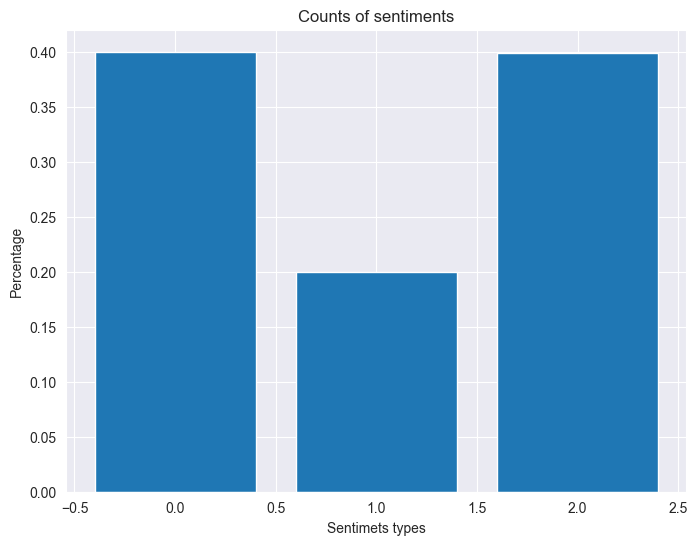

In [18]:
sentiment_density = dataset['sentiment'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
plt.bar(sentiment_density.index, sentiment_density.values)

# Add labels and title
plt.xlabel('Sentimets types')
plt.ylabel('Percentage')
plt.title('Counts of sentiments')

# Show the plot
plt.show()

As we expected the middle category is less present. This is important during training

### Language cleaning

Author specifies that there are some reviews not in English. Let's use fasttext, developed by Facebook, to find the languages.

In [49]:
languages_text = compute_languages(dataset['text'])

Now check the distributions of languages

In [50]:
languages_text.value_counts()

text
__label__en     2991674
__label__es        5381
__label__ja        1512
__label__fr         556
__label__pt         258
__label__de         135
__label__it         126
__label__nl          22
__label__pl          20
__label__zh          14
__label__sr          13
__label__sv          11
__label__id           9
__label__tr           9
__label__ca           6
__label__la           5
__label__tl           4
__label__cy           4
__label__oc           4
__label__da           4
__label__ms           3
__label__hu           3
__label__sh           3
__label__sl           3
__label__el           2
__label__kn           2
__label__hr           2
__label__no           2
__label__ia           2
__label__fi           2
__label__ba           2
__label__ro           2
__label__eo           2
__label__cs           1
__label__lt           1
__label__is           1
__label__vec          1
__label__uk           1
__label__ru           1
__label__sc           1
__label__mk           1
__label__ml

There are instances not in English. Remove all not English reviews in title and text

In [51]:
dataset = remove_not_modal_languages(languages_text)(dataset)
save_csv(dataset, ONLY_ENGLISH)

file saved


## Text preprocessing

Now we preprocessed the dataframe to be manipulated and used in deep learning methods and with LSA. The operations that are performed sequentially are:
- text to lower case
- tokenization, 
- expansion of contractions, 
- word correction, 
- stop word removal 
- punctuation removal

In [17]:
# processing_fn = normalise
# dataset['text'] = apply(dataset['text'], processing_fn)
dataset['text'] = TextPreprocessor().preprocess(dataset['text'])
save_csv(dataset, PREPROCESSED_DATASET)

100%|██████████| 2991674/2991674 [16:03<00:00, 3106.22it/s]


file saved


In [21]:
# grouped = train.groupby('stars')['text'].apply(lambda x: ' '.join(x)).reset_index()
# for star_rating, reviews in zip(grouped['stars'], grouped['text']):
#   word_cloud(reviews, f'Word cloud for {star_rating} stars')
  
# Concatenate the aggregated reviews into a single string

## LSA analysis

### Compute TF-IDF

In [46]:
tfidf_sparse, words = tf_idf(dataset['text'], 
                             min_df=3, 
                             max_df=0.95, 
                             ngram_range=(1, 4),
                             max_features=10_000)
print(f'{len(words)} words founded')

10000 words founded


In [67]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(min_df=3, 
                             max_df=0.95, 
                             ngram_range=(1, 4),
                             max_features=10_000)
count_matrix = count_vectorizer.fit_transform(dataset['text'])

In [48]:
# TODO capire come funziona/come fare
def get_most_relevant_phrases(tfidf_sparse, words):
    # Sort features by weight.
    tfidf_row_sums = np.asarray(tfidf_sparse.sum(axis=1)).flatten()
    tfidf_sorting = np.argsort(tfidf_row_sums)[::-1]
    # Get the top eight most weighted features.
    top_n = words[tfidf_sorting[:len(words)]][:8]
    return top_n

get_most_relevant_phrases(tfidf_sparse, words)

IndexError: index 437907 is out of bounds for axis 0 with size 10000

In [90]:

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import CountVectorizer

# Sample dataset (replace with your Amazon reviews dataset)
data = dataset

# Create a CountVectorizer with binary=True to work with a sparse DTM
vectorizer = CountVectorizer(max_features=20_000,
                             binary=True)
dtm = vectorizer.fit_transform(data['text'])

# Get the feature names (terms)
feature_names = vectorizer.get_feature_names_out()

In [91]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import CountVectorizer
from joblib import Parallel, delayed
import multiprocessing

# Define the sentiment classes
sentiment_classes = ["good", "neutral", "bad"]

# Initialize dictionaries to store chi-square scores and p-values
chi2_scores = {}
p_values = {}

# Define a function to calculate chi-square scores in parallel
def calculate_chi2(term):
    i = np.where(feature_names == term)[0][0]
    chi2_matrix = pd.crosstab(dtm[:, i].toarray().flatten(), data['sentiment'])
    chi2, p, _, _ = chi2_contingency(chi2_matrix)
    return term, chi2, p

# Parallelize the computation
num_cores = multiprocessing.cpu_count()
results = [calculate_chi2(term) for term in tqdm(feature_names)]

# Extract results and populate the dictionaries
for term, chi2, p in results:
    chi2_scores[term] = chi2
    p_values[term] = p

# Create DataFrames for chi-square scores and p-values
chi2_df = pd.DataFrame.from_dict(chi2_scores, orient='index', columns=['Chi2_Score'])
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['P_Value'])

# Combine the results
result_df = pd.concat([chi2_df, p_values_df], axis=1)

# Get the top 5 terms for each sentiment class based on chi-square scores
top_terms_good = result_df[result_df.index.isin(sentiment_classes)].nlargest(5, 'Chi2_Score')
top_terms_neutral = result_df[result_df.index.isin(sentiment_classes)].nsmallest(5, 'Chi2_Score')
top_terms_bad = result_df[result_df.index.isin(sentiment_classes)].nlargest(5, 'Chi2_Score')

print("Top 5 Terms for 'good' Sentiment:")
print(top_terms_good)

print("\nTop 5 Terms for 'neutral' Sentiment:")
print(top_terms_neutral)

print("\nTop 5 Terms for 'bad' Sentiment:")
print(top_terms_bad)




  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 1/20000 [00:00<1:01:20,  5.43it/s]

  0%|          | 3/20000 [00:00<38:06,  8.74it/s]  

  0%|          | 5/20000 [00:00<32:12, 10.35it/s]

  0%|          | 7/20000 [00:00<28:52, 11.54it/s]

  0%|          | 9/20000 [00:00<27:26, 12.14it/s]

  0%|          | 11/20000 [00:00<26:32, 12.55it/s]

  0%|          | 13/20000 [00:01<25:41, 12.97it/s]

  0%|          | 15/20000 [00:01<25:17, 13.17it/s]

  0%|          | 17/20000 [00:01<25:01, 13.30it/s]

  0%|          | 19/20000 [00:01<26:28, 12.58it/s]

  0%|          | 21/20000 [00:01<25:23, 13.11it/s]

  0%|          | 23/20000 [00:01<25:39, 12.98it/s]

  0%|          | 25/20000 [00:02<26:24, 12.61it/s]

  0%|          | 27/20000 [00:02<26:07, 12.74it/s]

  0%|          | 29/20000 [00:02<25:31, 13.04it/s]

  0%|          | 31/20000 [00:02<25:21, 13.12it/s]

  0%|          | 33/20000 [00:02<25:01, 13.30it/s]

  0%|          | 35/20000 [00:02<25:19, 13.14it/s]

  0%|          | 37/

Top 5 Terms for 'good' Sentiment:
          Chi2_Score   P_Value
bad      7259.084271  0.000000
good     6282.049851  0.000000
neutral    25.723512  0.000003

Top 5 Terms for 'neutral' Sentiment:
          Chi2_Score   P_Value
neutral    25.723512  0.000003
good     6282.049851  0.000000
bad      7259.084271  0.000000

Top 5 Terms for 'bad' Sentiment:
          Chi2_Score   P_Value
bad      7259.084271  0.000000
good     6282.049851  0.000000
neutral    25.723512  0.000003


### Compute SVD decomposition

In [68]:
U, Sigma, V_T = randomized_svd(count_matrix, n_components=15)

In [58]:
U, Sigma, V_T = randomized_svd(tfidf_sparse, n_components=15)

In [59]:
print(f'U shape: {U.shape}')
print(U)

U shape: (500000, 15)
[[ 5.78845970e-04 -3.83173228e-04 -3.59684876e-04 ...  1.69197390e-03
  -8.36047621e-04  1.06382014e-03]
 [ 8.42397066e-04 -6.45661356e-04 -9.61642149e-04 ...  2.31368342e-03
  -1.13808855e-03  2.40363888e-04]
 [ 1.67598543e-03 -9.64966347e-04 -1.17427378e-03 ...  1.07681240e-03
  -5.68061086e-04  7.51629956e-04]
 ...
 [ 1.66223458e-03 -9.34107544e-04 -8.68577680e-04 ...  2.47474258e-03
   9.86691087e-06  2.18783727e-04]
 [ 9.50223753e-04 -6.00645229e-04 -8.27666637e-04 ... -3.42951760e-04
   1.39877108e-04  2.20495909e-03]
 [ 1.11424633e-03 -9.14235212e-04 -1.20434208e-03 ...  9.22449261e-04
  -9.39383733e-04  2.66139971e-03]]


In [60]:
print(f'Sigma {Sigma.shape}')
print(Sigma)

Sigma (15,)
[91.22079231 55.37060744 47.7581797  41.75677976 34.98475608 34.071143
 33.9141733  33.15999282 32.66629479 30.91280148 29.95743045 29.30533904
 28.78402059 28.45152994 28.05894384]


In [61]:
print(f'V transposed {V_T.shape}')
print(V_T)

V transposed (15, 10000)
[[ 9.94336276e-04  8.45723664e-04  8.09372033e-04 ...  1.72110098e-03
   1.81938768e-03  1.68496340e-03]
 [ 1.93868757e-05 -2.12877830e-04 -3.97267019e-04 ... -2.16328003e-03
  -1.33624266e-03 -1.81351172e-03]
 [ 1.89266045e-04 -6.69286754e-04 -3.86042461e-05 ...  3.14665622e-03
  -7.14223406e-04 -2.06104623e-03]
 ...
 [-8.52775392e-04 -5.69910172e-04 -5.53469218e-04 ...  6.72050391e-04
  -3.11338462e-04  9.80490541e-04]
 [ 4.18916850e-04  6.85915689e-04  1.48785965e-03 ... -1.31257715e-03
  -3.87739914e-04 -1.72240333e-04]
 [-4.52867201e-04 -6.82084833e-04  5.91932858e-04 ...  1.27356475e-03
  -2.13249743e-04 -3.31030808e-03]]


[1242.78702808  814.65451221  591.72037991  504.32336671  468.74870439
  457.98188938  443.02352151  411.51652697  407.56744229  370.9262049 ]


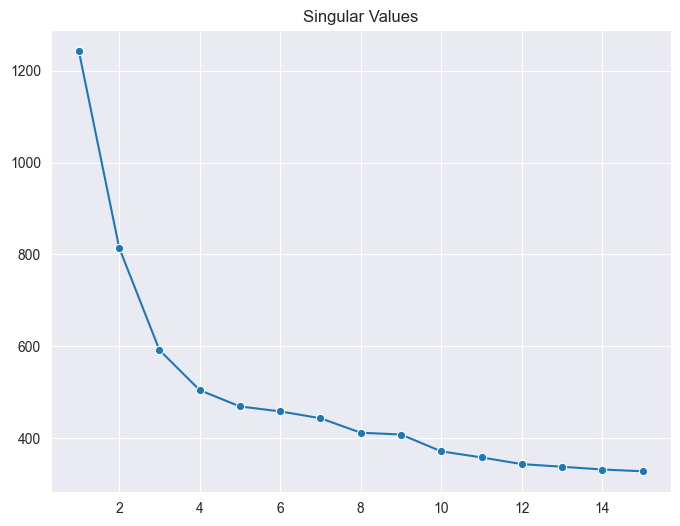

In [69]:
print(Sigma[:10])
plot_singular_values(Sigma)

In [70]:
terms_lsa =  V_T.T @ diag(Sigma)
normalized_terms_lsa = normalize_by_rows(terms_lsa)
documents_lsa = U @ diag(Sigma)
normalized_documents_lsa = normalize_by_rows(documents_lsa)

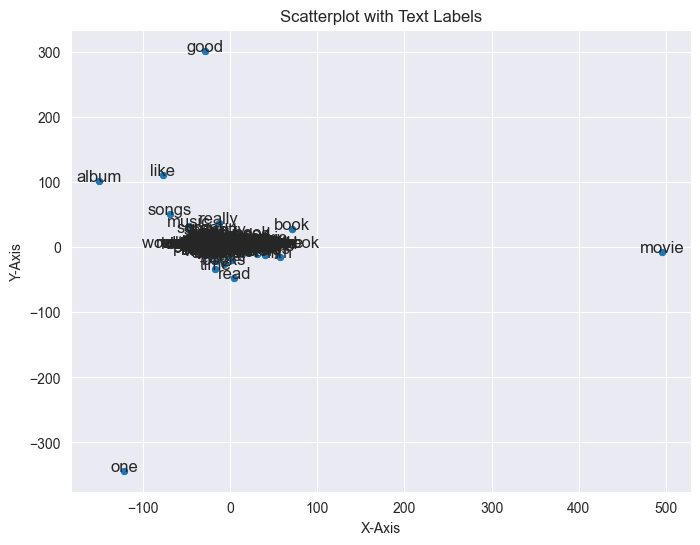

In [71]:
# Create a Seaborn scatterplot
plt.figure(figsize=(8, 6))
threshold = 5
mask = normalized_terms_lsa > threshold
data = terms_lsa[mask, :][:, 2:4]
texts = words[mask]
sns.scatterplot(x=data[:, 0], y=data[:, 1])

# Add text labels under each point
for (x, y), word in zip(data, texts):
    plt.text(x, y - 0.3, word, ha='center', fontsize=12)

# Add labels, title, and adjust plot settings as needed
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Scatterplot with Text Labels')
plt.grid(True)

# Show the plot
plt.show()

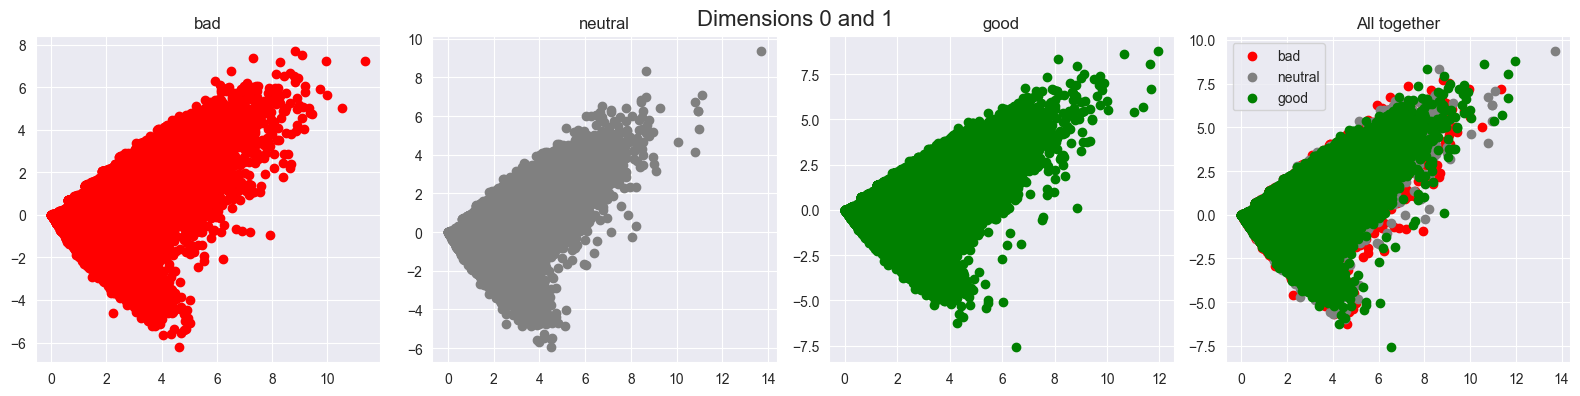

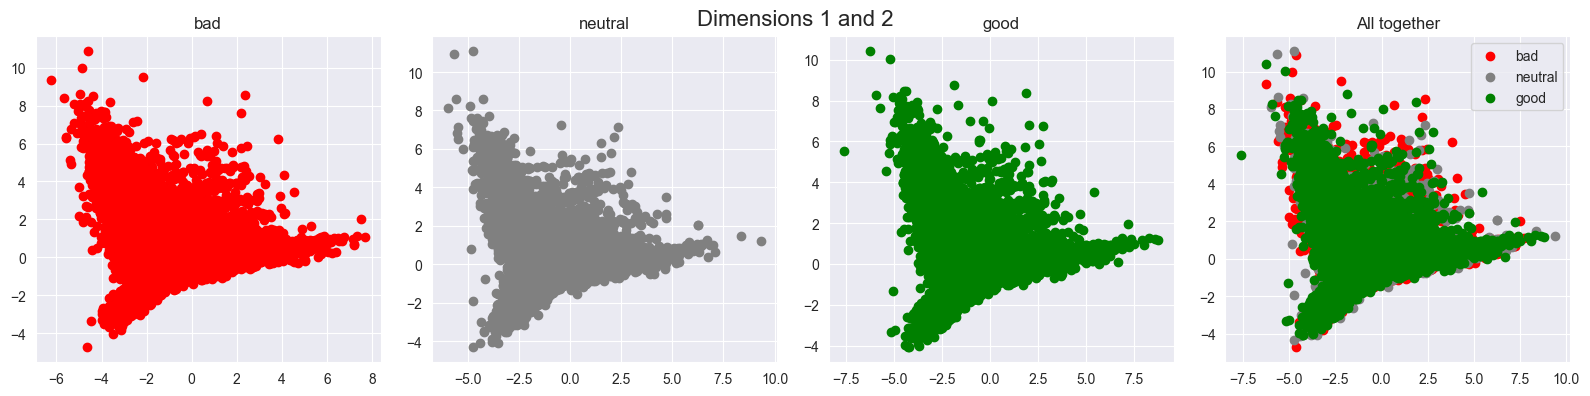

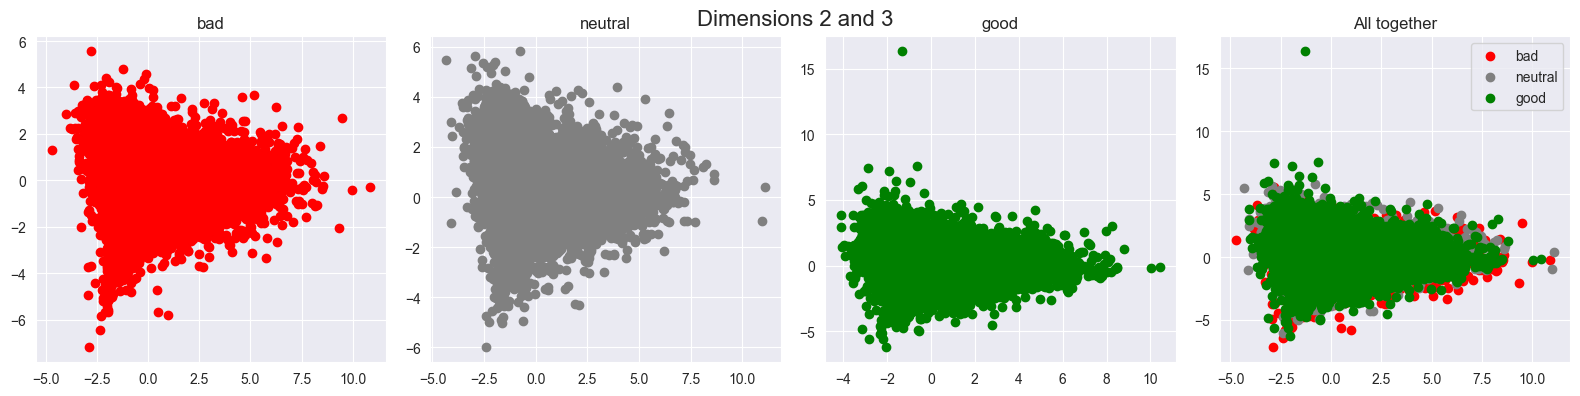

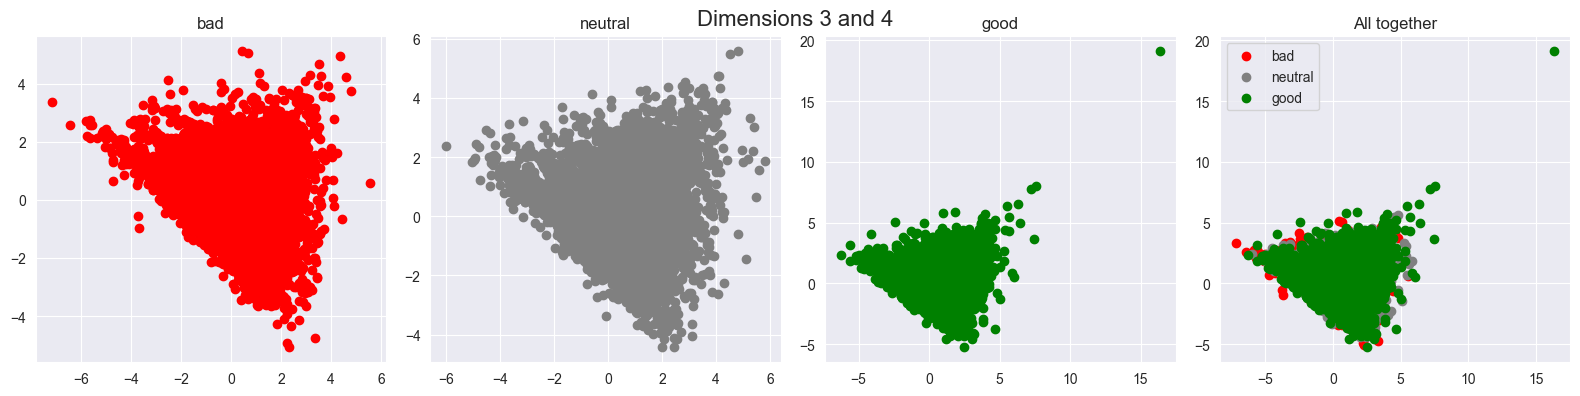

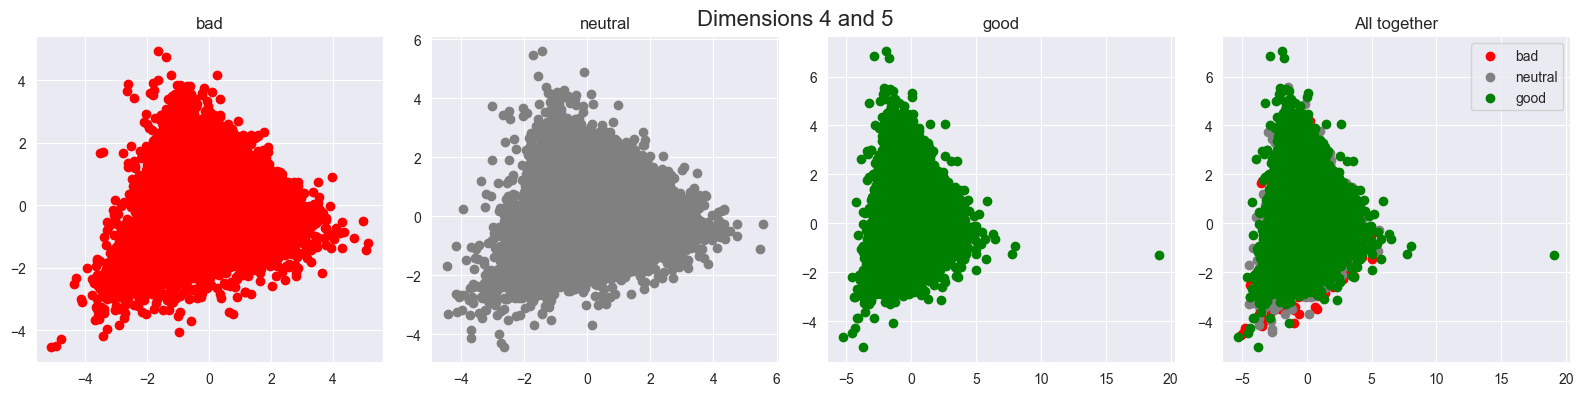

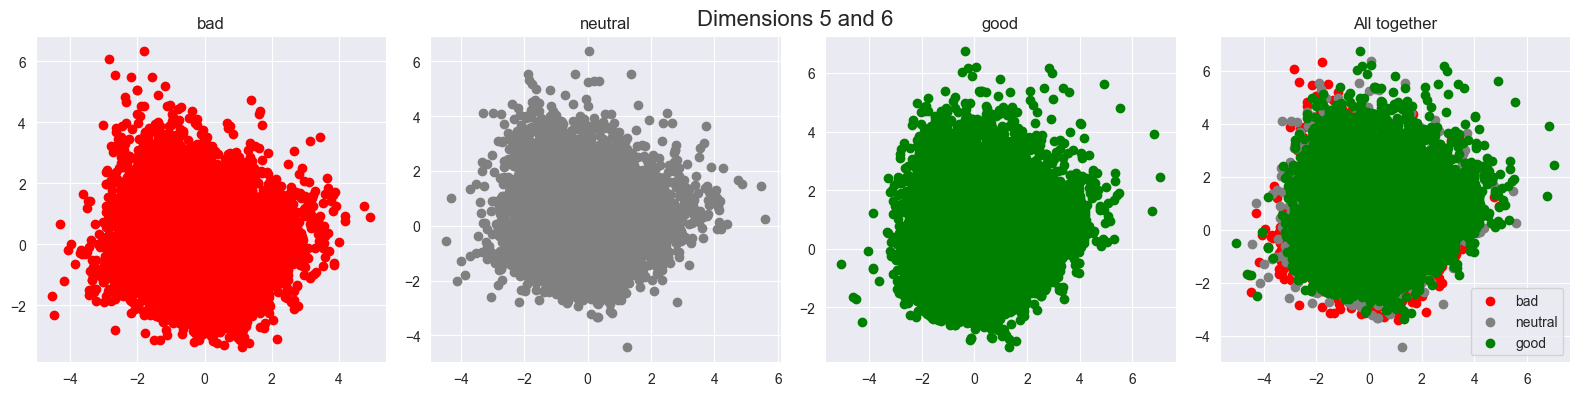

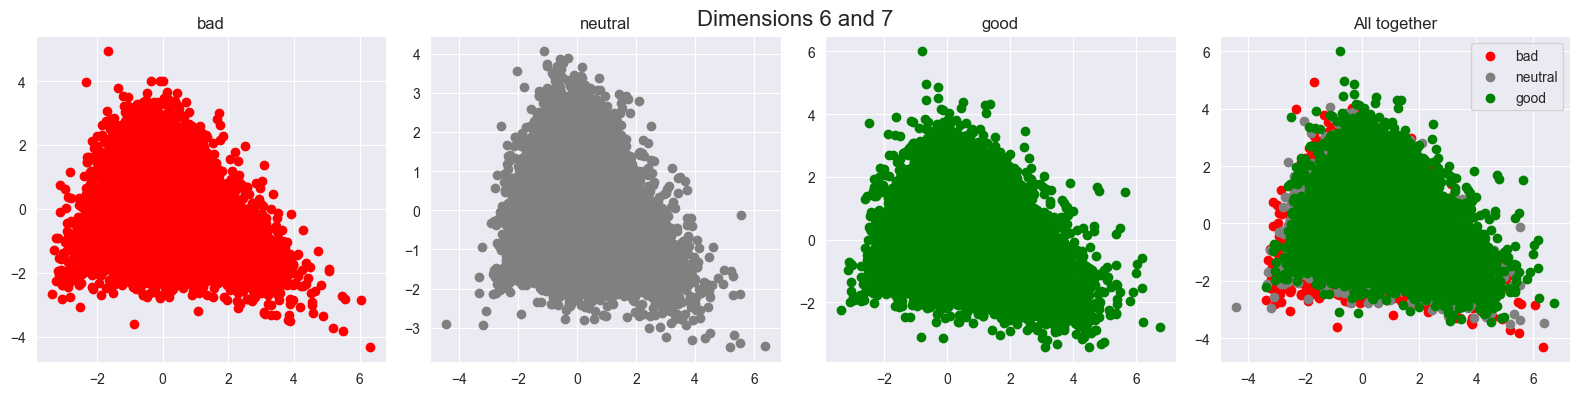

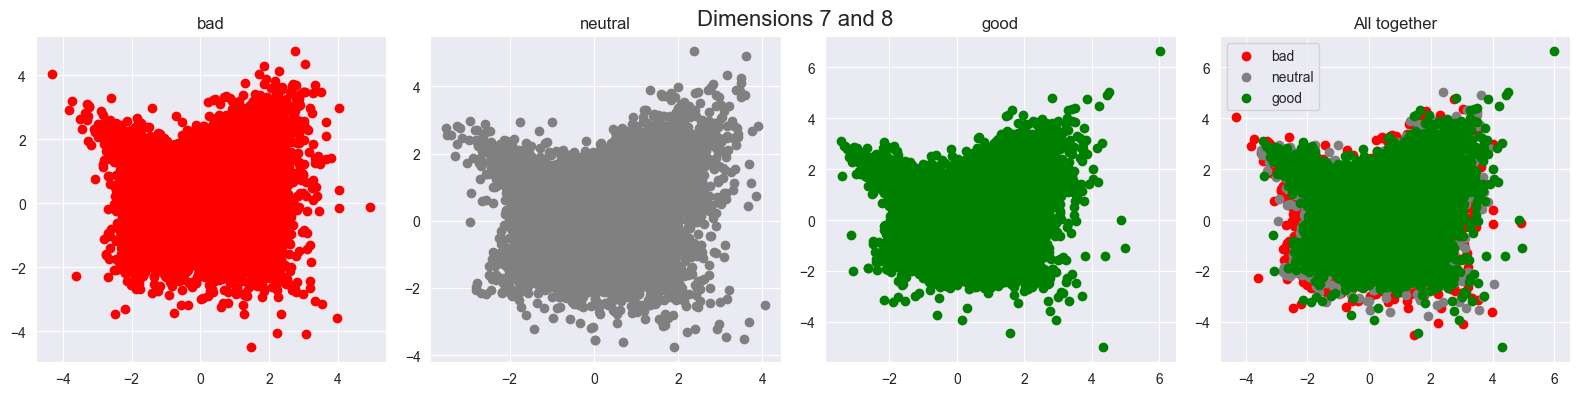

In [75]:
categories = dataset['sentiment'].values

# Define a color mapping for categories
color_mapping = {
    0: 'red',
    1: 'gray',
    2: 'green',
}

sentiment_mapping = {
    0: 'bad',
    1: 'neutral',
    2: 'good',
}

# Create a scatter plot for each category
for i in range(8):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for j, (category, color) in enumerate(color_mapping.items()):
        x = documents_lsa[categories == category, i]
        y = documents_lsa[categories == category, i+1]
        
        ax = axes[j]
        ax.scatter(x, y, c=color, label='Scatter 1')
        ax.set_title(sentiment_mapping[category])
        # Adjust layout to prevent overlap
        plt.tight_layout()
    
    for j, (category, color) in enumerate(color_mapping.items()):
        x = documents_lsa[categories == category, i]
        y = documents_lsa[categories == category, i+1]
        
        scatter = axes[3].scatter(documents_lsa[categories == category, i], 
                                  documents_lsa[categories == category, i+1], 
                                  c=color_mapping[category],
                                  label=f'{sentiment_mapping[category]}')
    axes[3].legend()
    axes[3].set_title("All together")
        # Adjust layout to prevent overlap
    
    plt.suptitle(f'Dimensions {i} and {i+1}', fontsize=16)
    # Show the plot
    plt.show()


In [31]:
#########################################################################################

In [32]:
X = dataset.text
y = dataset.stars

In [33]:
train_x, test_x, train_y, test_y = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)
print(f'Train size: {len(train_y)}')
print(f'Test size: {len(test_y)}')


Train size: 20000
Test size: 5000


In [34]:
vectorizer = TfidfVectorizer().fit(train_x)
train_features = vectorizer.transform(train_x)
test_features = vectorizer.transform(test_x)

In [35]:
model = SVC()
distributions = {'C': uniform(loc=0, scale=1), 'kernel': ['poly', 'rbf', 'sigmoid']}

In [36]:
clf = RandomizedSearchCV(model, distributions, 
                         scoring='accuracy', 
                         cv=5, 
                         n_iter=3, 
                         # n_jobs=-1,
                         verbose=2)

best_svm_model = clf.fit(train_features, train_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..................C=0.8895507662222324, kernel=poly; total time= 2.3min


KeyboardInterrupt: 

In [ ]:
print(f'Best Accuracy Score: {round(best_svm_model.best_score_, 3)}')
print(f'Best Hyperparameters: {best_svm_model.best_params_}')

## Non neural models

### Data preparation

In [118]:
train_x, test_x, train_y, test_y = train_test_split(dataset['text'], 
                                                    dataset['sentiment'], 
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE)
Y_weight = compute_class_weights(train_y)

train size: 8000, test size: 2000


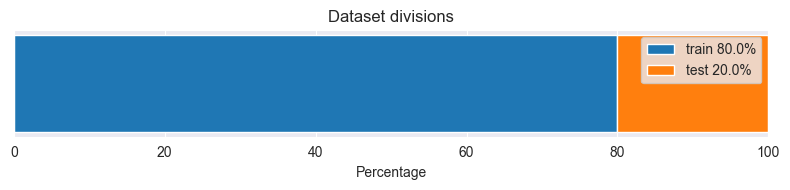

In [119]:
plot_divisions(train_y, test_y)

In [70]:
# Create a TF-IDF vectorizer to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer(min_df=3, 
                                   max_df=0.95, 
                                   ngram_range=(1, 4),
                                   max_features=10_000)

X_train_tfidf = tfidf_vectorizer.fit_transform(train_x)
X_test_tfidf = tfidf_vectorizer.transform(test_x)

KeyboardInterrupt: 

### CatBoost

In [11]:
param_space = {
    'depth': (4, 10),            # Depth of the trees
    'learning_rate': (0.01, 0.5),  # Learning rate
    'iterations': (1, 1)#(50, 1000),     # Number of iterations
}
fit_params = {
    'sample_weight': Y_weight, 
    'verbose': True,
    'task_type': 'GPU'
}


best_model, best_params = bayes_grid_search(CatBoostClassifier, 
                               param_space, 
                               X_train_tfidf,
                               train_y,
                               fixed_params={'loss_function': 'MultiClass'},
                               fit_params=fit_params,
                               init_points=0,
                               cv = 2,
                               n_iter=1)
save_binary_model(best_model, CAT_BOOST)

|   iter    |  target   |   depth   | iterat... | learni... |
-------------------------------------------------------------
0:	learn: 1.0751250	total: 1.59s	remaining: 0us
0:	learn: 1.0747702	total: 1.41s	remaining: 0us
| 1         | 0.352     | 5.149     | 1.0       | 0.2245    |
0:	learn: 1.0408509	total: 19.9s	remaining: 0us
0:	learn: 1.0383440	total: 20.3s	remaining: 0us
| 2         | 0.5016    | 9.999     | 1.0       | 0.452     |
0:	learn: 1.0394431	total: 30.4s	remaining: 0us
{'depth': 9, 'learning_rate': 0.4520199605776817, 'iterations': 1, 'loss_function': 'MultiClass'}


In [13]:
# Make predictions on the TF-IDF transformed test data
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the model
classification_rep = classification_report(test_y, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.51      0.75      0.60     39652
           1       0.29      0.28      0.29     20207
           2       0.67      0.37      0.47     40141

    accuracy                           0.50    100000
   macro avg       0.49      0.46      0.45    100000
weighted avg       0.53      0.50      0.49    100000


## Deep neural networks

### Data preparation

In [160]:
shuffled_data = dataset.sample(frac=1, random_state=RANDOM_STATE)
X = dataset['text']
y = keras.utils.to_categorical(dataset['sentiment'], num_classes=len(set(dataset['sentiment'])))

(train_x, 
 validation_x, 
 test_x, 
 train_y, 
 validation_y, 
 test_y) = split_continuously(X, y, partitions=[0.8, 0.1, 0.1])

full_train_x = pd.concat([train_x, validation_x])
full_train_y = np.vstack([train_y, validation_y])

train size: 8000, test size: 1000, validation size: 1000


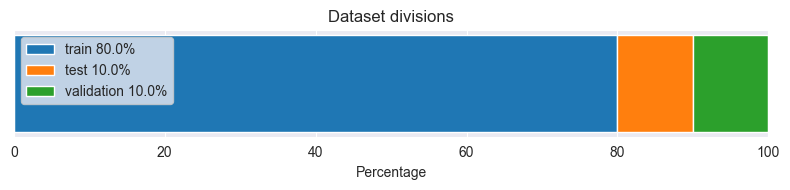

In [161]:
plot_divisions(train_y, test_y, validation_y)

In [171]:
mlen = max(len(train_ex) for train_ex in train_x)
#vocabulary = list(set(word for string in train_x for word in string.split()))[:MAX_TOKENS]
vectorize_layer = TextVectorization(standardize=None,    
                                    max_tokens=MAX_TOKENS,
                                    output_sequence_length=mlen)
vectorize_layer.adapt(train_x)

### Training parameters

In [172]:
def callbacks(model_name: str):
    return [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'{MODELS_FOLDER}/{model_name}', 
                        monitor='val_accuracy', 
                        save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5)
    ]

### 1D CNN

In [173]:
model_name = 'CNN'
model = build_model([
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 256),
    
    layers.Conv1D(256, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(3),
    
    layers.Conv1D(128, 5),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(5),
    
    layers.Conv1D(64, 5),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.GlobalMaxPooling1D(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
])

In [174]:
history = model.fit(train_x, 
          train_y,
          batch_size=BATCH_SIZE,
          #epochs=DEFAULT_EPOCHS,
          epochs=7,
          validation_data=(validation_x, validation_y),
          callbacks=callbacks(model_name))

Epoch 1/7
63/63 [==============================] - ETA: 0s - loss: 1.3588 - accuracy: 0.3795INFO:tensorflow:Assets written to: resources/models\CNN\assets


INFO:tensorflow:Assets written to: resources/models\CNN\assets


63/63 [==============================] - 82s 1s/step - loss: 1.3588 - accuracy: 0.3795 - val_loss: 1.0897 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 2/7
63/63 [==============================] - ETA: 0s - loss: 1.0730 - accuracy: 0.4156INFO:tensorflow:Assets written to: resources/models\CNN\assets


INFO:tensorflow:Assets written to: resources/models\CNN\assets


63/63 [==============================] - 86s 1s/step - loss: 1.0730 - accuracy: 0.4156 - val_loss: 1.0813 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 3/7
63/63 [==============================] - ETA: 0s - loss: 1.0283 - accuracy: 0.4819INFO:tensorflow:Assets written to: resources/models\CNN\assets


INFO:tensorflow:Assets written to: resources/models\CNN\assets


63/63 [==============================] - 87s 1s/step - loss: 1.0283 - accuracy: 0.4819 - val_loss: 1.0833 - val_accuracy: 0.4410 - lr: 0.0010
Epoch 4/7
63/63 [==============================] - ETA: 0s - loss: 0.8045 - accuracy: 0.6557INFO:tensorflow:Assets written to: resources/models\CNN\assets


INFO:tensorflow:Assets written to: resources/models\CNN\assets


63/63 [==============================] - 85s 1s/step - loss: 0.8045 - accuracy: 0.6557 - val_loss: 1.0680 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 5/7
63/63 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.7921INFO:tensorflow:Assets written to: resources/models\CNN\assets


INFO:tensorflow:Assets written to: resources/models\CNN\assets


63/63 [==============================] - 86s 1s/step - loss: 0.5055 - accuracy: 0.7921 - val_loss: 1.0272 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 6/7
63/63 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8775INFO:tensorflow:Assets written to: resources/models\CNN\assets


INFO:tensorflow:Assets written to: resources/models\CNN\assets


63/63 [==============================] - 87s 1s/step - loss: 0.3206 - accuracy: 0.8775 - val_loss: 0.9602 - val_accuracy: 0.5530 - lr: 0.0010
Epoch 7/7
63/63 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9413INFO:tensorflow:Assets written to: resources/models\CNN\assets


INFO:tensorflow:Assets written to: resources/models\CNN\assets


63/63 [==============================] - 90s 1s/step - loss: 0.1748 - accuracy: 0.9413 - val_loss: 0.9396 - val_accuracy: 0.5610 - lr: 0.0010


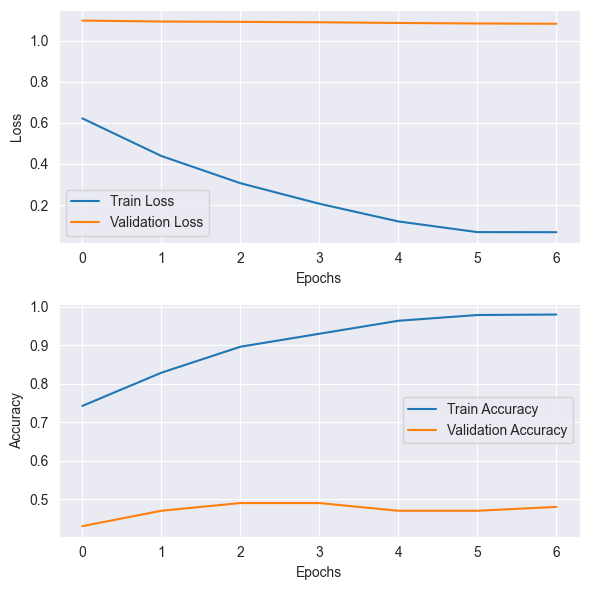

In [56]:
plot_history(history)

In [60]:
train_predictions = model.predict(full_train_x)
test_predictions = model.predict(test_x)

save_numpy(train_predictions, f'{BINARY_DATA}/{model_name}_train_predictions.npy')
save_numpy(test_predictions, f'{BINARY_DATA}/{model_name}_test_predictions.npy')

4/4 [==============================] - 0s 48ms/step


Scores for model train score is 0.4033333333333333, test score is 0.26


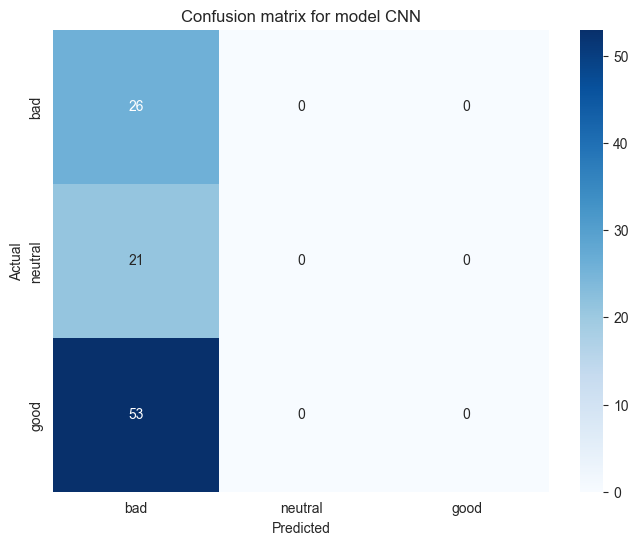

In [81]:
show_model_scores(train_predictions, full_train_y, test_predictions, test_y)

### GRU

In [82]:
model_name = 'GRU'
model = build_model([
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 128),
    layers.GRU(128, return_sequences=True),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32),
    layers.Dense(16, activation='relu')
])


In [84]:
history = model.fit(train_x, 
          train_y,
          batch_size=BATCH_SIZE,
          #epochs=DEFAULT_EPOCHS,
          epochs=5,
          validation_data=(validation_x, validation_y),
          callbacks=callbacks(model_name))

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 1.0770 - accuracy: 0.3487INFO:tensorflow:Assets written to: resources/models\model_name\assets


INFO:tensorflow:Assets written to: resources/models\model_name\assets


7/7 [==============================] - 48s 7s/step - loss: 1.0770 - accuracy: 0.3487 - val_loss: 1.0622 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 1.0754 - accuracy: 0.3862INFO:tensorflow:Assets written to: resources/models\model_name\assets


INFO:tensorflow:Assets written to: resources/models\model_name\assets


7/7 [==============================] - 46s 7s/step - loss: 1.0754 - accuracy: 0.3862 - val_loss: 1.0669 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - 45s 6s/step - loss: 1.0767 - accuracy: 0.3800 - val_loss: 1.0653 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 4/5
7/7 [==============================] - 43s 6s/step - loss: 1.0752 - accuracy: 0.3862 - val_loss: 1.0676 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 5/5
7/7 [==============================] - 46s 6s/step - loss: 1.0761 - accuracy: 0.3862 - val_loss: 1.0728 - val_accuracy: 0.3100 - lr: 0.0010


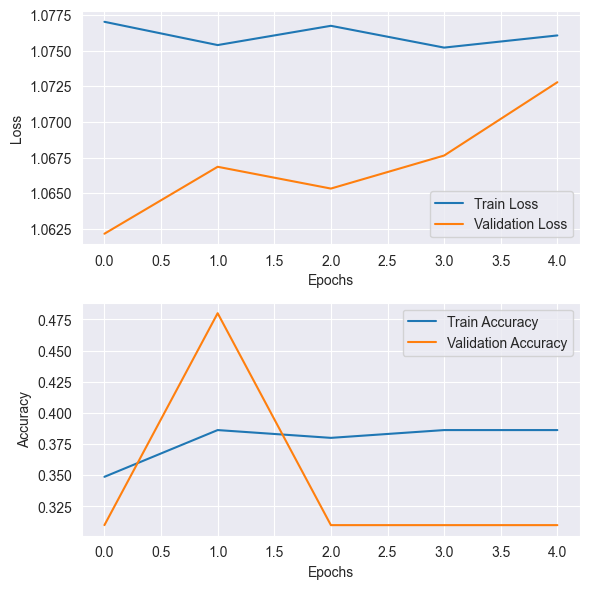

In [85]:
plot_history(history)

In [86]:
train_predictions = model.predict(full_train_x)
test_predictions = model.predict(test_x)

save_numpy(train_predictions, f'{BINARY_DATA}/{model_name}_train_predictions.npy')
save_numpy(test_predictions, f'{BINARY_DATA}/{model_name}_test_predictions.npy')

4/4 [==============================] - 1s 198ms/step


Scores for model train score is 0.37777777777777777, test score is 0.53


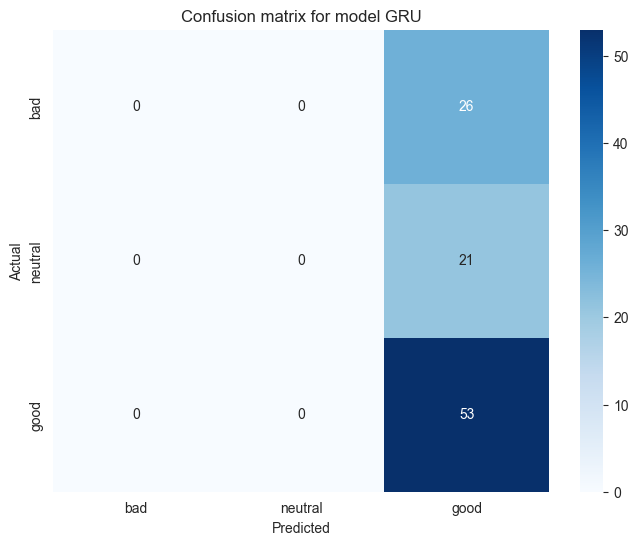

In [87]:
show_model_scores(train_predictions, full_train_y, test_predictions, test_y)

### LSTM

In [89]:
model_name = 'LSTM'
model = build_model([
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 128),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(16, activation='relu')
])

In [90]:
history = model.fit(train_x, 
          train_y,
          batch_size=BATCH_SIZE,
          #epochs=DEFAULT_EPOCHS,
          epochs=5,
          validation_data=(validation_x, validation_y),
          callbacks=callbacks(model_name))

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 1.0876 - accuracy: 0.3675INFO:tensorflow:Assets written to: resources/models\LSTM\assets


INFO:tensorflow:Assets written to: resources/models\LSTM\assets


7/7 [==============================] - 59s 7s/step - loss: 1.0876 - accuracy: 0.3675 - val_loss: 1.0534 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - 53s 7s/step - loss: 1.0771 - accuracy: 0.3750 - val_loss: 1.0786 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - 51s 7s/step - loss: 1.0772 - accuracy: 0.3862 - val_loss: 1.0600 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 4/5
7/7 [==============================] - 51s 7s/step - loss: 1.0761 - accuracy: 0.3800 - val_loss: 1.0642 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 5/5
7/7 [==============================] - 51s 7s/step - loss: 1.0766 - accuracy: 0.3837 - val_loss: 1.0701 - val_accuracy: 0.3100 - lr: 0.0010


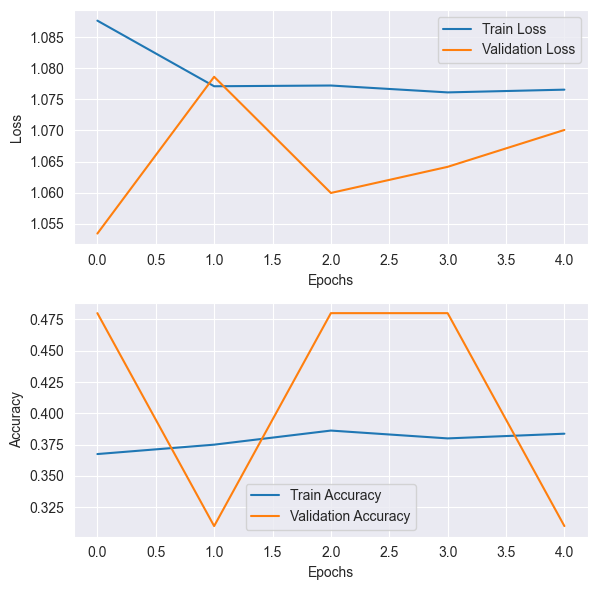

In [91]:
plot_history(history)

In [92]:
train_predictions = model.predict(full_train_x)
test_predictions = model.predict(test_x)

save_numpy(train_predictions, f'{BINARY_DATA}/{model_name}_train_predictions.npy')
save_numpy(test_predictions, f'{BINARY_DATA}/{model_name}_test_predictions.npy')

4/4 [==============================] - 1s 272ms/step


Scores for model train score is 0.37777777777777777, test score is 0.53


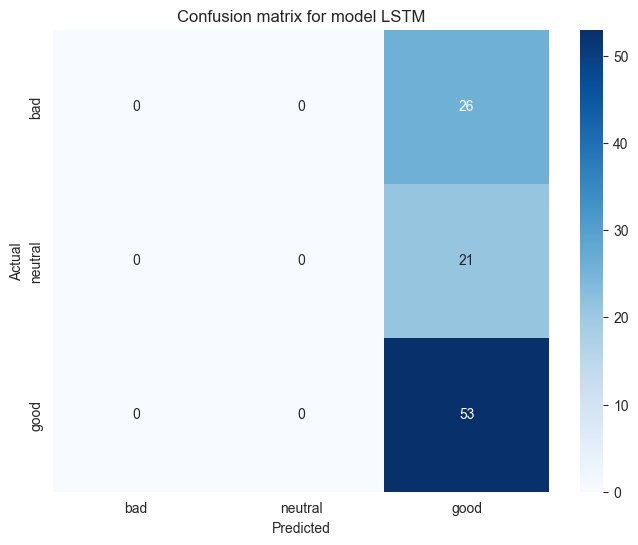

In [93]:
show_model_scores(train_predictions, full_train_y, test_predictions, test_y)

### Bidirectinal LSTM

In [94]:
model_name = 'Bidirectional_LSTM'
model = build_model([
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 128),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(16, activation='relu')
])

In [96]:
history = model.fit(train_x,
                    train_y,
                    batch_size=BATCH_SIZE,
                    #epochs=DEFAULT_EPOCHS,
                    epochs=3,
                    validation_data=(validation_x, validation_y),
                    callbacks=callbacks(model_name))

Epoch 1/3
7/7 [==============================] - ETA: 0s - loss: 1.0825 - accuracy: 0.4137 INFO:tensorflow:Assets written to: resources/models\Bidirectional_LSTM\assets


INFO:tensorflow:Assets written to: resources/models\Bidirectional_LSTM\assets


7/7 [==============================] - 221s 31s/step - loss: 1.0825 - accuracy: 0.4137 - val_loss: 1.0563 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 2/3
7/7 [==============================] - ETA: 0s - loss: 1.0566 - accuracy: 0.3975 INFO:tensorflow:Assets written to: resources/models\Bidirectional_LSTM\assets


INFO:tensorflow:Assets written to: resources/models\Bidirectional_LSTM\assets


7/7 [==============================] - 280s 40s/step - loss: 1.0566 - accuracy: 0.3975 - val_loss: 1.0250 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 3/3
7/7 [==============================] - ETA: 0s - loss: 0.9377 - accuracy: 0.6025 INFO:tensorflow:Assets written to: resources/models\Bidirectional_LSTM\assets


INFO:tensorflow:Assets written to: resources/models\Bidirectional_LSTM\assets


7/7 [==============================] - 311s 45s/step - loss: 0.9377 - accuracy: 0.6025 - val_loss: 1.0399 - val_accuracy: 0.5400 - lr: 0.0010


In [ ]:
plot_history(history)

In [ ]:
train_predictions = model.predict(full_train_x)
test_predictions = model.predict(test_x)

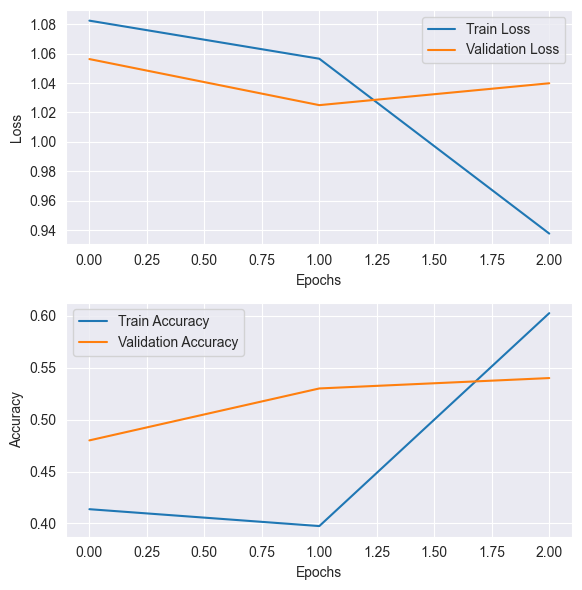

4/4 [==============================] - 8s 2s/step
Scores for model train score is 0.6711111111111111, test score is 0.35


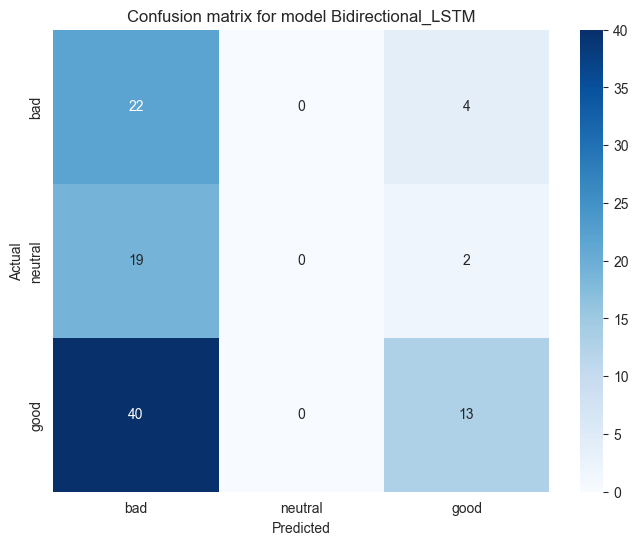

In [97]:
save_numpy(train_predictions, f'{BINARY_DATA}/{model_name}_train_predictions.npy')
save_numpy(test_predictions, f'{BINARY_DATA}/{model_name}_test_predictions.npy')
show_model_scores(train_predictions, full_train_y, test_predictions, test_y)